# Models Training (HSL) File

# 1. Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble, svm, neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 2. Define functions

In [2]:
# Method to convert RGB to HSL
def rgb_to_hsl(r, g, b):
        r /= 255
        g /= 255
        b /= 255
        max_val = max(r, g, b)
        min_val = min(r, g, b)
        diff = max_val - min_val
        h = s = l = (max_val + min_val) / 2

        if max_val == min_val:
            h = s = 0  # achromatic
        else:
            # saturation calculation
            if l > 0.5:
                s = diff / (2 - max_val - min_val)
            else:
                s = diff / (max_val + min_val)
            
            # hue calculation
            if max_val == r:
                h = (g - b) / diff + (g < b) * 6
            elif max_val == g:
                h = (b - r) / diff + 2
            else:
                h = (r - g) / diff + 4

            h /= 6

        return h, s, l

# Method to convert HSL to RGB
def hsl_to_rgb(h, s, l):
    if s == 0:
        r = g = b = l  # achromatic
    else:
        def hue_to_rgb(p, q, t):
            if t < 0:
                t += 1
            if t > 1:
                t -= 1
            if t < 1 / 6:
                return p + (q - p) * 6 * t
            if t < 1 / 2:
                return q
            if t < 2 / 3:
                return p + (q - p) * (2 / 3 - t) * 6
            return p

        q = l < 0.5 and l * (1 + s) or l + s - l * s
        p = 2 * l - q
        r = hue_to_rgb(p, q, h + 1 / 3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1 / 3)

    return [int(255 * r), int(255 * g), int(255 * b)]

# Method to convert RGB to hexadecimal
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

# Define a function to train, save, and evaluate a model
def train_save_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Create /data directory if doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
        
    # Save the model
    try:
        model_path = f"data/{model_name}_hsl.joblib"
        joblib.dump(model, model_path)
        print(f"Model saved at: {os.path.abspath(model_path)}")
    except Exception as e:
        print("Error occurred: {e}")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
   
    return y_pred, mae, mse, rmse, r2

# Define a function to load pre-trained model
def load_model(model_name):
    # Define the model path
    model_path = f"data/{model_name}.joblib"
    
    # Check if the model exists
    if not os.path.exists(model_path):
        print(f"No model found at: {os.path.abspath(model_path)}")
        return None

    # Load the model
    try:
        model = joblib.load(model_path)
        print(f"Model loaded from: {os.path.abspath(model_path)}")
    except Exception as e:
        print("Error occurred: {e}")

    return model

# 3. Hyperparamters

In [3]:
REFERENCE_FILE = "reference_2.csv"
METRIC_RESULT_FILE = "metrics_hsl.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 2
NAME_OF_LABEL = "Protein Level"

# 4. Load data

In [4]:
# Load data from .csv file
reference_df = pd.read_csv(os.path.join("data", REFERENCE_FILE))
# Create the dictionary
reference = {(r['Red'], r['Green'], r['Blue']): r['Label'] for _, r in reference_df.iterrows()}

# Create arrays for features and target variable
X = []
y = []

# Iterate over rows in the dataframe
for _, r in reference_df.iterrows():
    h, s, l = rgb_to_hsl(r['Red'], r['Green'], r['Blue'])
    X.append([h, s, l])
    y.append(r['Label'])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 4.1. Plot overall data

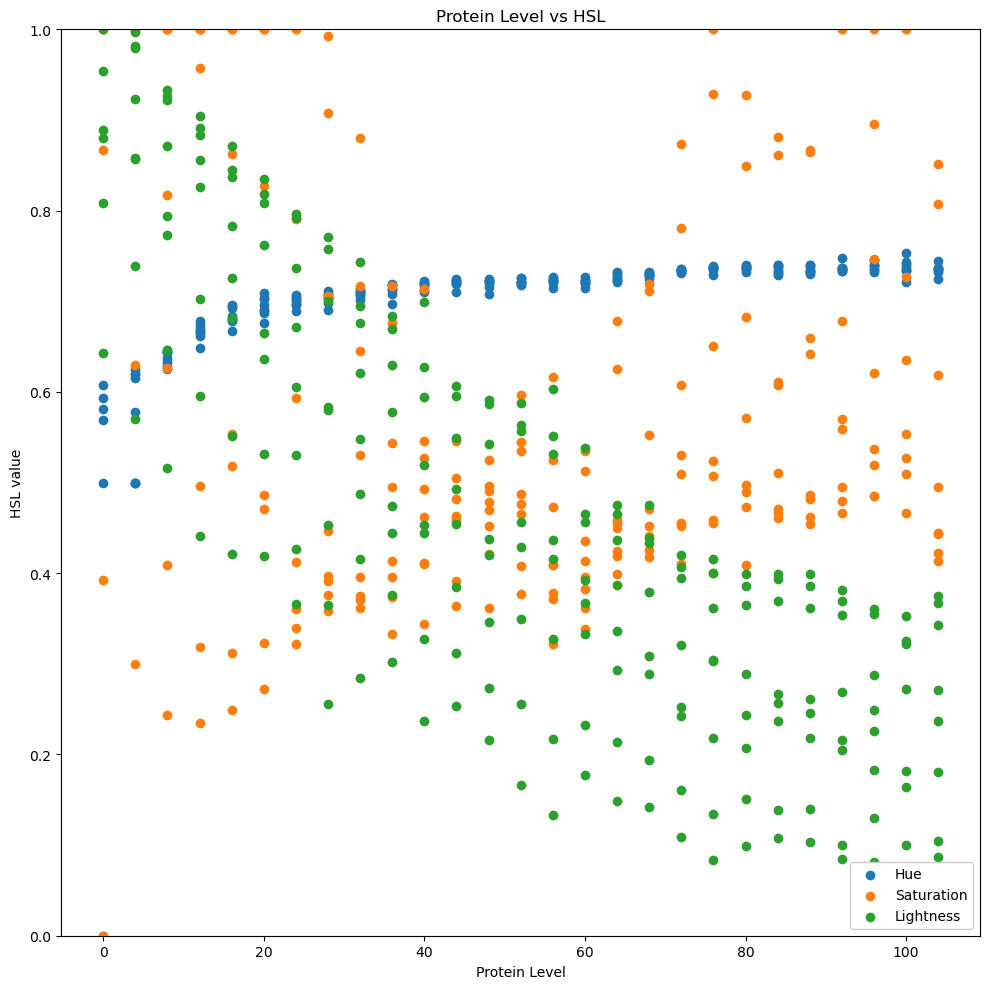

In [5]:
# Convert RGB values to HSL and normalize RGB for coloring
hue_reference = [rgb_to_hsl(k[0], k[1], k[2])[0] for k in reference.keys()]
saturation_reference = [rgb_to_hsl(k[0], k[1], k[2])[1] for k in reference.keys()]
lightness_reference = [rgb_to_hsl(k[0], k[1], k[2])[2] for k in reference.keys()]
colors = [(k[0]/255, k[1]/255, k[2]/255) for k in reference.keys()]

# Prepare pH values
labels = list(reference.values())

# Create subplots
fig, axs = plt.subplots(figsize=(10, 10))

# Plot pH vs Hue
axs.scatter(labels, hue_reference, label='Hue')
axs.set_xlabel(NAME_OF_LABEL)
axs.set_ylabel('HSL value')
axs.set_ylim([0, 1])

# Plot pH vs Saturation
axs.scatter(labels, saturation_reference, label='Saturation')

# Plot pH vs Lightness
axs.scatter(labels, lightness_reference, label='Lightness')

axs.set_title(f'{NAME_OF_LABEL} vs HSL')

# Add legend to the plot
axs.legend(loc='lower right', framealpha=1)

# Display the plots
plt.tight_layout()
plt.show()

## 4.2. Plot each feature

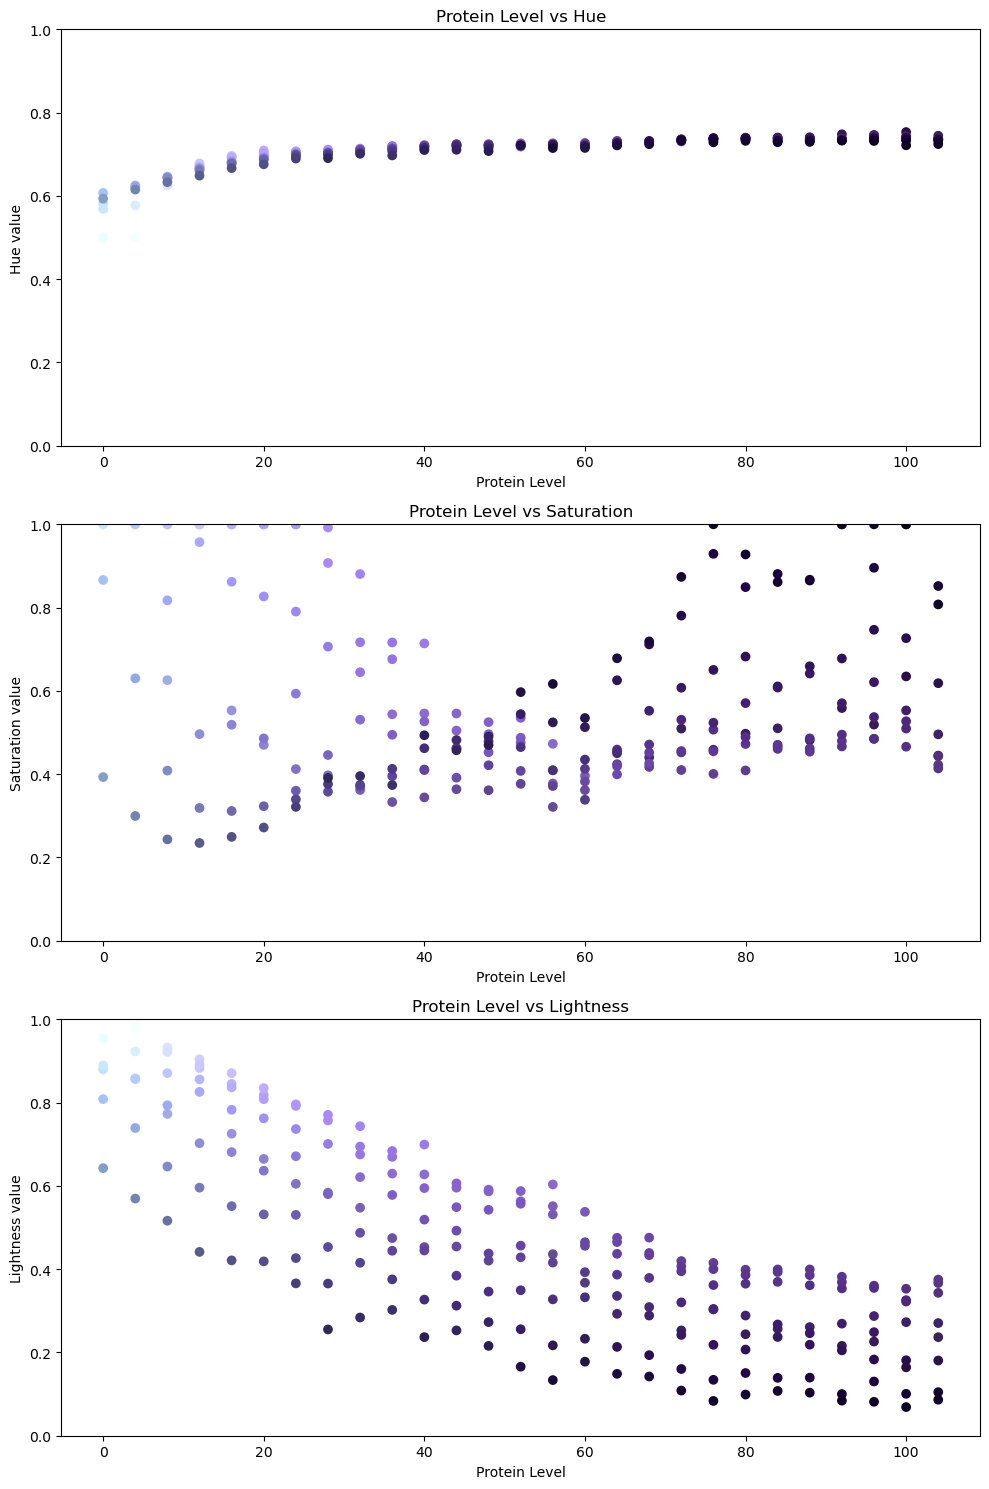

In [6]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot pH vs Hue
axs[0].scatter(labels, hue_reference, color=colors)
axs[0].set_xlabel(NAME_OF_LABEL)
axs[0].set_ylabel('Hue value')
axs[0].set_ylim([0, 1])
axs[0].set_title(f'{NAME_OF_LABEL} vs Hue')

# Plot pH vs Saturation
axs[1].scatter(labels, saturation_reference, color=colors)
axs[1].set_xlabel(NAME_OF_LABEL)
axs[1].set_ylabel('Saturation value')
axs[1].set_ylim([0, 1])
axs[1].set_title(f'{NAME_OF_LABEL} vs Saturation')

# Plot pH vs Lightness
axs[2].scatter(labels, lightness_reference, color=colors)
axs[2].set_xlabel(NAME_OF_LABEL)
axs[2].set_ylabel('Lightness value')
axs[2].set_ylim([0, 1])
axs[2].set_title(f'{NAME_OF_LABEL} vs Lightness')

# Display the plots
plt.tight_layout()
plt.show()

# 5. Train and evaluate models

In [7]:
# Models and their names
models = {
    "random_forest": ensemble.RandomForestRegressor(n_estimators=1000),
    "gradient_boosting": ensemble.GradientBoostingRegressor(n_estimators=1000),
    "svm": svm.SVR(),
    "neural_network": neural_network.MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=10000, early_stopping=True, random_state=1)
}

# Define the parameter grids for each model
param_grids = {
    "random_forest": {
        "n_estimators": [500, 1000, 2000],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
    "gradient_boosting": {
        "n_estimators": [500, 1000, 2000],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10],
    },
    "svm": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto", 0.1, 1],
    },
    "neural_network": {
        "hidden_layer_sizes": [(50, 30), (100, 50), (200, 100)],
        "activation": ["relu", "tanh"],
    },
}

# DataFrame to hold the results
results = pd.DataFrame(columns=["Model", "MAE", "MSE", "RMSE"])

# Train, save, and evaluate each model
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")
    
    # Update the model with the best parameters
    best_model = grid_search.best_estimator_

    y_pred, mae, mse, rmse, r2 = train_save_evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name)
    temp_df = pd.DataFrame({"Model": [model_name], "MAE": [mae], "MSE": [mse], "RMSE": [rmse], "R^2": [r2]})
    results = pd.concat([results, temp_df])

# Save the metrics to a .csv file
try:
    results.to_csv(os.path.join("data", METRIC_RESULT_FILE), index=False)
    print(f"Metrics saved at: {os.path.abspath(METRIC_RESULT_FILE)}")
except Exception as e:
    print(f"Error occurred: {e}")

Best parameters for random_forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Best score for random_forest: 0.9148134002303605
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\random_forest_hsl.joblib
Best parameters for gradient_boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score for gradient_boosting: 0.9159018998188152
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\gradient_boosting_hsl.joblib
Best parameters for svm: {'C': 10, 'gamma': 'scale'}
Best score for svm: 0.7587766096912638
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\svm_hsl.joblib
Best parameters for neural_network: {'activation': 'relu', 'hidden_layer_sizes': (200, 100)}
Best score for neural_network: 0.7388174634463763
Model saved at: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\neural_network_hsl.joblib
Metrics saved 

In [8]:
results.head(5)

,Model,MAE,MSE,RMSE,R^2
0,random_forest,5.307455,63.533226,7.970773,0.948460
0,gradient_boosting,5.041439,53.225993,7.295615,0.956821
0,svm,7.862842,119.867596,10.948406,0.902760
0,neural_network,34.153640,1443.723231,37.996358,-0.171193


# 6. Load models and predict

In [9]:
# Initialize DataFrame to store predictions
predictions_df = pd.DataFrame()
predictions_df['HSL'] = list(X_test)  # Converting X_test to list
predictions_df['RGB'] = predictions_df['HSL'].apply(lambda hsl: hsl_to_rgb(*hsl)) # Convert HSL back to RGB
predictions_df['color'] = predictions_df['RGB'].apply(lambda rgb: rgb_to_hex(*rgb))
predictions_df['y_test'] = y_test

# Model names
model_names = ["random_forest_hsl", "gradient_boosting_hsl", "svm_hsl", "neural_network_hsl"]

# Load each model, generate predictions and save to DataFrame
for model_name in model_names:
    model = load_model(model_name)
    if model is not None:
        predictions_df[model_name] = model.predict(X_test)

# Sort DataFrame by 'y_test' in ascending order
predictions_df = predictions_df.sort_values(by='y_test', ascending=True)

# Reset the index of the DataFrame
predictions_df.reset_index(drop=True, inplace=True)

Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\random_forest_hsl.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\gradient_boosting_hsl.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\svm_hsl.joblib
Model loaded from: d:\johmi\Projects\Research Projects\Color_Sensor\Programs\dev_0.1.0\data\neural_network_hsl.joblib


# 7. Visualize

## 7.1. Plot predictions

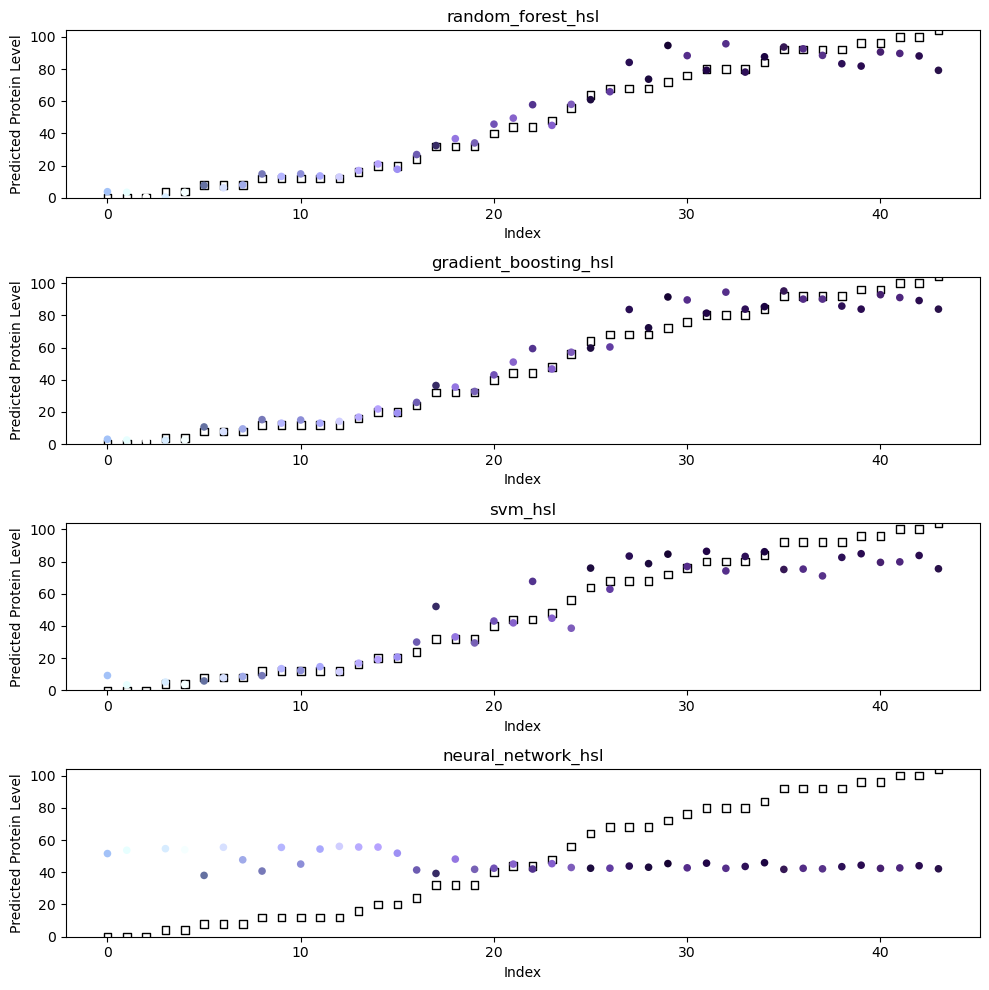

In [10]:
global_min = np.min([predictions_df[model].min() for model in model_names])
global_max = np.max([predictions_df[model].max() for model in model_names])
global_min = min(global_min, predictions_df['y_test'].min())
global_max = max(global_max, predictions_df['y_test'].max())

# Create a scatter plot for each model's predictions
fig, axes = plt.subplots(nrows=len(model_names), figsize=(10, 10))

for i, model_name in enumerate(model_names):
    axes[i].scatter(predictions_df.index, predictions_df['y_test'], facecolors='none', edgecolors='black', s=30, marker='s')
    axes[i].scatter(predictions_df.index, predictions_df[model_name], c=predictions_df['color'], edgecolors='none', s=30)
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Predicted {NAME_OF_LABEL}')
    axes[i].set_ylim([global_min, global_max])  # Set the y-axis limits

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

## 7.2. Plot residuals

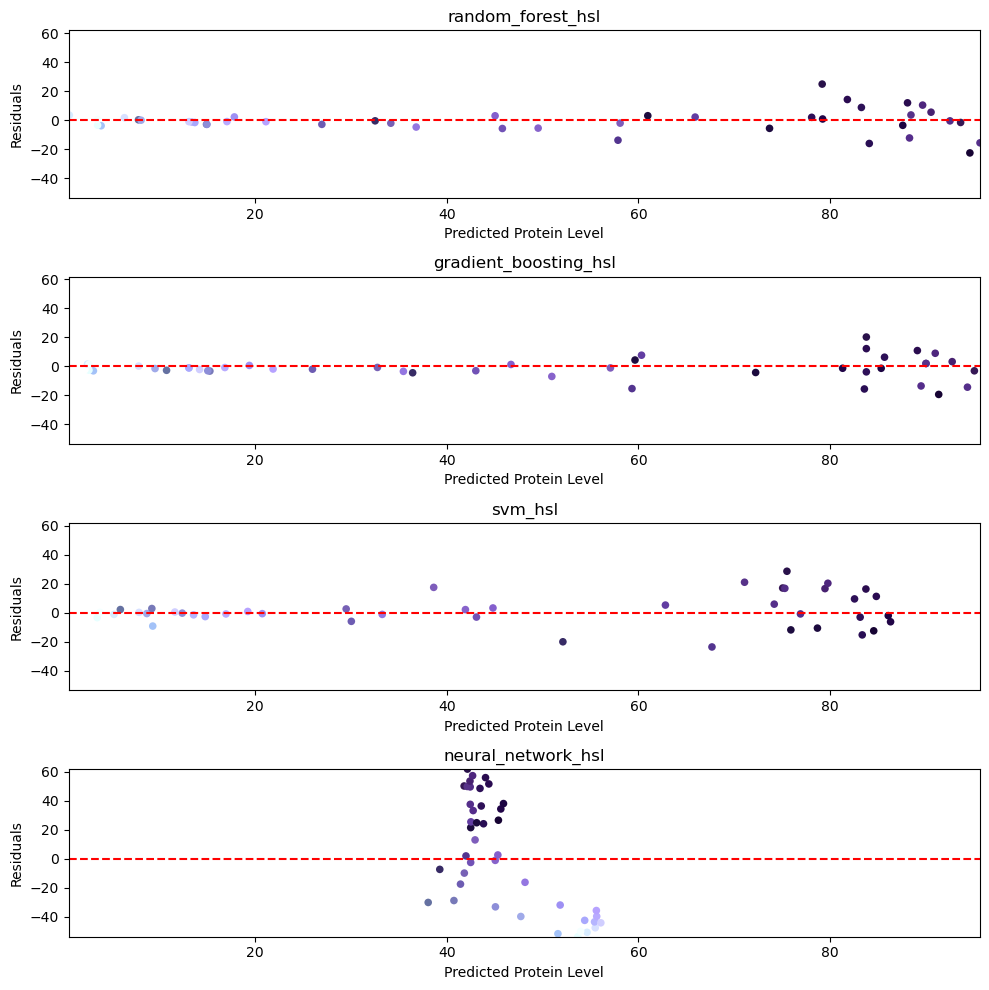

In [11]:
# Get global min and max of predicted values and residuals for all models
global_min_x = np.min([predictions_df[model].min() for model in model_names])
global_max_x = np.max([predictions_df[model].max() for model in model_names])

global_min_y = np.min([(predictions_df['y_test'] - predictions_df[model]).min() for model in model_names])
global_max_y = np.max([(predictions_df['y_test'] - predictions_df[model]).max() for model in model_names])

# Create a residual plot for each model's predictions
fig, axes = plt.subplots(nrows=len(model_names), figsize=(10, 10))

for i, model_name in enumerate(model_names):
    residuals = predictions_df['y_test'] - predictions_df[model_name]
    axes[i].scatter(predictions_df[model_name], residuals, c=predictions_df['color'], edgecolors='none', s=30)
    axes[i].set_title(model_name)
    axes[i].set_xlabel(f'Predicted {NAME_OF_LABEL}')
    axes[i].set_ylabel('Residuals')
    axes[i].axhline(y=0, color='r', linestyle='--')  # Draw a horizontal line at y=0
    axes[i].set_xlim([global_min_x, global_max_x])  # Set the x-axis limits
    axes[i].set_ylim([global_min_y, global_max_y])  # Set the y-axis limits

# Adjust the layout
plt.tight_layout()

# Display the plots
plt.show()

## 7.3. Plot overall predictions

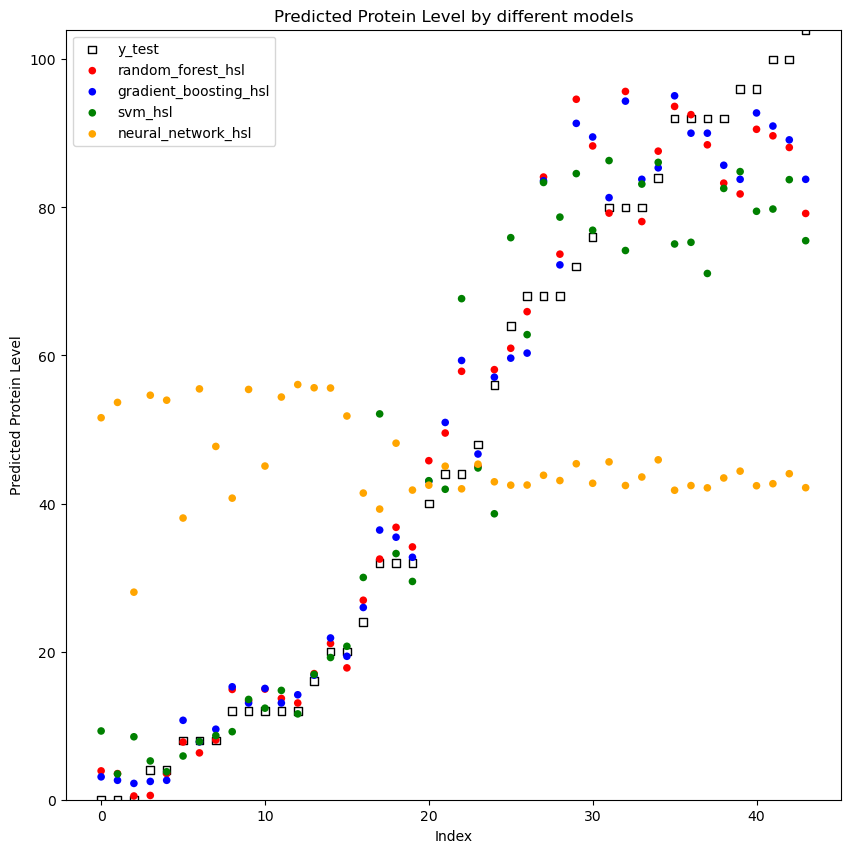

In [12]:
# Create a scatter plot for each model's predictions
fig, ax = plt.subplots(figsize=(10, 10))

# Define a list of colors for the models
colors = ['red', 'blue', 'green', 'orange']

ax.scatter(predictions_df.index, predictions_df['y_test'], facecolors='none', edgecolors='black', s=30, marker='s', label='y_test')

for model_name, color in zip(model_names, colors):
    ax.scatter(predictions_df.index, predictions_df[model_name], color=color, edgecolors='none', s=30, label=model_name)

ax.set_title(f'Predicted {NAME_OF_LABEL} by different models')
ax.set_xlabel('Index')
ax.set_ylabel(f'Predicted {NAME_OF_LABEL}')
ax.set_ylim([global_min, global_max])  # Set the y-axis limits
ax.legend()  # Show a legend

# Display the plot